<a href="https://colab.research.google.com/github/lcbjrrr/quant/blob/master/J_RegLin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Topic:** AI/ML

**Title:** Linear Regression

**Author:** Luiz Barboza

**Date:** 20/dec/22

**Lang:** Julia

**Site:** https://quant-research.group/

**Email:** contato@quant-research.group


# Julia Installation

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.3 on the current Colab Runtime...
2022-12-21 11:19:13 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.3-linux-x86_64.tar.gz [130030846/130030846] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8


In [ ]:
versioninfo()

Julia Version 1.8.3
Commit 0434deb161e (2022-11-14 20:14 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  LD_PRELOAD = /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
  JULIA_NUM_THREADS = 2


# Linear Regression

In [ ]:
import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Statistics")
Pkg.add("StatsPlots")
Pkg.add("GLM")
Pkg.add("MLBase")
Pkg.add("Lathe") 
using CSV
using DataFrames
using Statistics
using StatsPlots
using GLM
using MLBase
using Lathe
using Lathe.preprocess: TrainTestSplit


In [ ]:
Pkg.add("Lathe")  
using Lathe

In [ ]:
;wget https://raw.githubusercontent.com/lcbjuk/ML/master/dados/notas%20-%20ok.csv 

In [ ]:
;wget https://raw.githubusercontent.com/lcbjrrr/data/main/notas%20-%20tr.csv

In [ ]:
;wget https://raw.githubusercontent.com/lcbjrrr/data/main/notas%20-%20ts.csv

In [ ]:
#read csv: train data
train=CSV.read("notas - tr.csv", DataFrame)
first(train,5)

Row,AP1,AP2,AP3
,Float64,Float64,Float64
1,10.0,10.0,9.0
2,9.0,10.0,9.0
3,9.5,10.0,10.0
4,9.4,9.9,9.9
5,9.3,9.8,9.8


In [ ]:
#read csv: test data
test=CSV.read("notas - tr.csv", DataFrame)
first(test,3)

Row,AP1,AP2,AP3
,Float64,Float64,Float64
1,10.0,10.0,9.0
2,9.0,10.0,9.0
3,9.5,10.0,10.0


In [ ]:
#read csv: all
df=CSV.read("notas - ok.csv", DataFrame)
first(test,3)

Row,AP1,AP2,AP3
,Float64,Float64,Float64
1,10.0,10.0,9.0
2,9.0,10.0,9.0
3,9.5,10.0,10.0


## Correlation and Scatterplot

In [ ]:
#Correlation
cor(df.AP2,df.AP3)

0.952690666552573

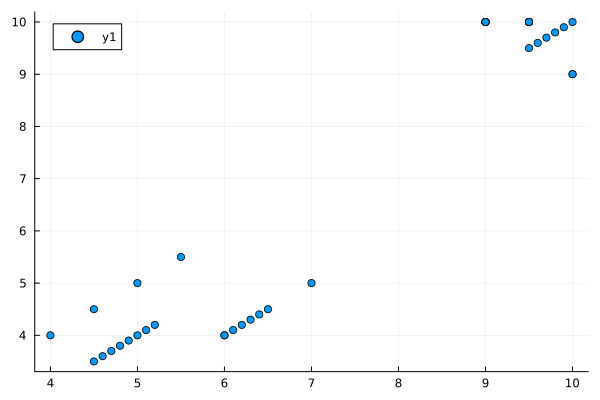

In [ ]:
scatter(df.AP2,df.AP3)

## Linear Regression

In [ ]:
train, test = TrainTestSplit(df,.80)

(31×4 DataFrame
 Row │ AP1      AP2      AP3      Final   
     │ Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────
   1 │    10.0     10.0      9.0     9.8
   2 │     9.0     10.0      9.0     9.4
   3 │     9.5     10.0     10.0     9.8
   4 │     9.2      9.7      9.7     9.5
   5 │     9.0      9.5      9.5     9.3
   6 │    10.0      7.0      5.0     7.8
   7 │     9.5      6.5      4.5     7.3
   8 │     9.4      6.4      4.4     7.2
   9 │     9.3      6.3      4.3     7.1
  10 │     9.2      6.2      4.2     7.0
  11 │     9.1      6.1      4.1     6.9
  ⋮  │    ⋮        ⋮        ⋮        ⋮
  22 │     5.5      5.5      5.5     5.5
  23 │     5.0      9.0     10.0     7.6
  24 │     5.1      9.5     10.0     7.84
  25 │     5.2      9.5     10.0     7.88
  26 │     5.3      9.5     10.0     7.92
  27 │     5.4      9.5     10.0     7.96
  28 │     4.9      9.0     10.0     7.56
  29 │     4.7      9.0     10.0     7.48
  30 │     4.5      9.0     10.

In [ ]:
linreg = lm(@formula(AP3 ~ AP1 + AP2), train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

AP3 ~ 1 + AP1 + AP2

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.49022    0.309468    -1.58    0.1244  -1.12414    0.143698
AP1          -0.387663   0.0341381  -11.36    <1e-11  -0.457592  -0.317734
AP2           1.35408    0.0359722   37.64    <1e-24   1.28039    1.42776
──────────────────────────────────────────────────────────────────────────

In [ ]:
function predict_ap3(ap1, ap2)
  ap3 = -0.387663*ap1 + 1.35408*ap2 + -0.49022
  return ap3
end
predict_ap3(8,8)

7.241116

In [ ]:
pred_train = predict(linreg,train)

31-element Vector{Union{Missing, Float64}}:
  9.173937968727834
  9.561601070981625
  9.36776951985473
  9.077844793705417
  8.88456164293921
  5.111701400473335
  4.628493523557813
  4.531851948174708
  4.4352103727916035
  4.3385687974085005
  4.241927222025396
  4.145285646642291
  4.535142350338827
  ⋮
  4.3418591995726175
  3.8586513226570958
  4.82506707648814
  9.758174623911952
 10.396447741728991
 10.357681431503611
 10.318915121278232
 10.280148811052854
  9.79694093413733
  9.87447355458809
  9.952006175038846
  9.990772485264225

In [ ]:
r2(linreg)

0.9806904975645492

In [ ]:
pred_test=predict(linreg,test)

9-element Vector{Union{Missing, Float64}}:
  9.271127944471626
  9.174486369088521
  8.981203218322314
  4.145285646642291
  4.245217624189514
  3.9552928980402005
 10.241382500827473
  9.835707244362709
  9.913239864813468

In [ ]:
function MSE(y, pred)
  df = DataFrame(y = y, pred = pred)
  df.error = df[!,:y] - df[!,:pred]
  df.error_sq = df.error.*df.error
  mean(df.error_sq)
end

MSE (generic function with 1 method)

In [ ]:
function R2(y,pred)
  df = DataFrame(y = y, pred = pred)
  avg_y = mean(y)
  df.y_diff_sq = (df.y .- avg_y) .* (df.y .- avg_y)
  sum_y_diff_sq = sum(df.y_diff_sq)
  df.error = df[!,:y] - df[!,:pred]
  df.error_sq = df.error.*df.error  
  sum_pred_diff_sq = sum(df.error_sq)
  r2 = 1 - sum_pred_diff_sq/sum_y_diff_sq
  return r2
end

R2 (generic function with 1 method)

In [ ]:
mse_test = MSE(test.AP3,pred_test)
rmse_test = sqrt(mse_test)
r2_test = R2(test.AP3,pred_test)
print("\nMSE Test: ",mse_test)
print("\nRMSE Test: ",rmse_test)
print("\nR2 Test: ",r2_test)


MSE Test: 0.16988421495361522
RMSE Test: 0.4121701286527388
R2 Test: 0.9791751847646072

In [48]:
mse_train = MSE(train.AP3,pred_train)
rmse_train = sqrt(mse_train)
r2_train = R2(train.AP3,pred_train)
print("\nMSE train: ",mse_train)
print("\nRMSE train: ",rmse_train)
print("\nR2 train: ",r2_train)


MSE train: 0.14926828083509477
RMSE train: 0.38635253439714196
R2 train: 0.9806904975645492